# Insult Detection Preprocessing
This notebook preprocesses text data for insult detection in social media comments.
The dataset contains labeled tweets categorized into different types of cyberbullying.
We will clean and standardize the text to prepare it for feature extraction and model training.


In [13]:
# Installations
!pip install spacy emoji tqdm
!python -m spacy download en_core_web_sm  # Downloading small English model
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 46.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [14]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import spacy
import re
import emoji
from tqdm import tqdm
from langdetect import detect
import langdetect

## Dataset Loading
We start by loading the dataset and inspecting its structure.
Ensure the dataset is correctly placed in the directory before running this notebook.


In [15]:
# Load the dataset
df = pd.read_csv("cyberbullying_tweets.csv")

# Display the first few rows
df.head()


,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


## Data Exploration
Before preprocessing, we examine the dataset structure:
- Check for missing values.
- Analyze class distribution to detect any imbalances.


tweet_text            0
cyberbullying_type    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB
None


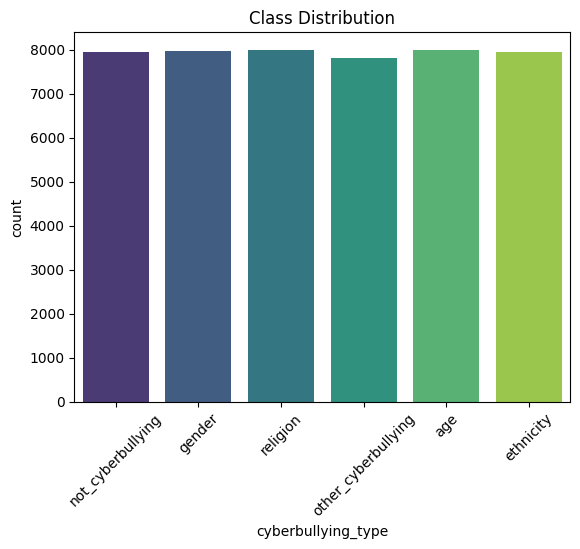

In [16]:
# Checking for missing values
print(df.isnull().sum())

# Displaying dataset info
print(df.info())

# Showing class distribution
sns.countplot(data=df, x='cyberbullying_type', hue='cyberbullying_type', palette='viridis', legend=False)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()



 We notice that The dataset is currently balanced across different bullying categories.

 If we merge all cyberbullying types into one "insult" category, the dataset will become imbalanced.
 And if we keep it multiclass, many insults will be classified as "other_cyberbullying," which reduces the model’s precision.

 we will opt for a hybrid approach where we convert the dataset into binary classification, but balance it manually to avoid class imbalance.

<ipython-input-17-da7a37a9d11a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['binary_label'], palette='viridis')


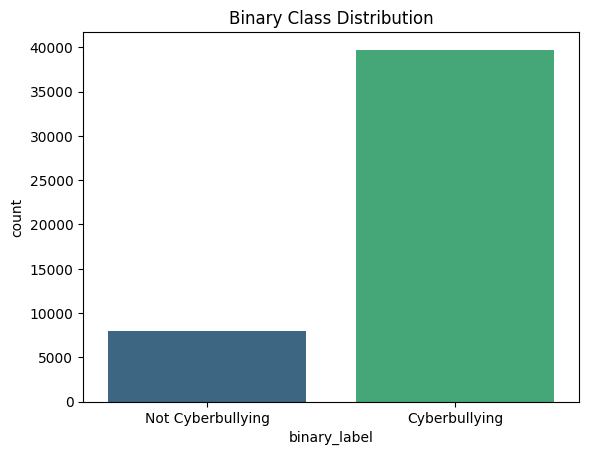

In [17]:
# Converting labels: Everything except 'not_cyberbullying' becomes 1 (insult)
df['binary_label'] = df['cyberbullying_type'].apply(lambda x: 1 if x != 'not_cyberbullying' else 0)

# Showing distribution
sns.countplot(x=df['binary_label'], palette='viridis')
plt.title("Binary Class Distribution")
plt.xticks([0,1], ['Not Cyberbullying', 'Cyberbullying'])
plt.show()

In [18]:
# Computing class weights
class_weights = compute_class_weight("balanced", classes=np.unique(df['binary_label']), y=df['binary_label'])
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 3.001384518565135, 1: 0.5999446499106851}


## Preprocessing

### Text Cleaning
We remove unnecessary elements from the text:
- Mentions (@usernames) to avoid bias.
- URLs, which do not contribute to sentiment analysis.
- Special characters and numbers, keeping only alphabetic text.

## Tokenization & Lemmatization
To standardize text input:
- Tokenization splits text into individual words.
- Stopwords (common words like "the", "is") are removed.
- Lemmatization converts words to their base form (e.g., "running" → "run").


In [19]:
# Loading the SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Initializing progress tracking
tqdm.pandas()

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [20]:
def clean_text_spacy(text):
    # Converting to lowercase
    text = text.lower()

    # Removing emojis
    text = emoji.replace_emoji(text, replace="")

    # Removing mentions (@usernames)
    text = re.sub(r'@\w+', '', text)

    # Removing URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Removing special characters, numbers, and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Detecting language (skip if detection fails)
    try:
        lang = detect(text)
        if lang != "en":
            return None  # Mark non-English text for removal
    except langdetect.lang_detect_exception.LangDetectException:
        return None

    # Processing text using SpaCy
    doc = nlp(text)

    # Removing stopwords and lemmatize words
    words = [token.lemma_ for token in doc if not token.is_stop]

    return " ".join(words)

# Applying cleaning
df['clean_text'] = df['tweet_text'].progress_apply(clean_text_spacy)

# Dropping non-English rows
df.dropna(subset=['clean_text'], inplace=True)

# Resetting index
df.reset_index(drop=True, inplace=True)

# Displaying cleaned data
df.head(10)

100%|██████████| 47692/47692 [13:48<00:00, 57.55it/s]


,tweet_text,cyberbullying_type,binary_label,clean_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,0,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,0,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,0,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,0,meh p thank head concerned angry dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,0,isis account pretend kurdish account like ...
5,"@Raja5aab @Quickieleaks Yes, the test of god i...",not_cyberbullying,0,yes test god good bad indifferent weird pro...
6,Karma. I hope it bites Kat on the butt. She is...,not_cyberbullying,0,karma hope bite kat butt nasty mkr
7,@stockputout everything but mostly my priest,not_cyberbullying,0,priest
8,Rebecca Black Drops Out of School Due to Bully...,not_cyberbullying,0,rebecca black drop school bully
9,The Bully flushes on KD http://twitvid.com/A2TNP,not_cyberbullying,0,bully flush kd


## Reordred the dataframe

In [22]:
df.rename(columns={'binary_label': 'insulting'}, inplace=True)  # Rename if needed

In [24]:
df = df[['insulting', 'clean_text']]
df

,insulting,clean_text
0,0,word katandandre food crapilicious mkr
1,0,aussietv white mkr theblock imacelebrityau tod...
2,0,classy whore red velvet cupcake
3,0,meh p thank head concerned angry dude twitter
4,0,isis account pretend kurdish account like ...
...,...,...
44089,1,black ppl not expect depend free participate w...
44090,1,turner withhold disappointment turner call cou...
44091,1,swear god dumb nigger bitch get bleach hair re...
44092,1,yea fuck rt nigger fucking unfollow fucking ...


## Shuffeling the data
Shuffling ensures the model learns from diverse examples rather than memorizing the order of data. This improves generalization and prevents bias.  

In [31]:
from sklearn.utils import shuffle

# Shuffle the dataset
df = shuffle(df, random_state= 45).reset_index(drop=True)

df

,insulting,clean_text
0,1,nigger white different thing racist dumb fuc...
1,1,fucking nigger africa shut fuck dumb asshole
2,1,nigger dirtydisguste use race happen people ...
3,0,kat andre not deserve hope destroy group round...
4,1,not believe abundance comedy sole punchline ...
...,...,...
44089,0,high achieve latinos not conform stereotype vu...
44090,1,lol think prob people not tow main stream l...
44091,1,little specific muslim country not tell isis t...
44092,1,want drink rant online harassment complex miti...


## Save the Cleaned Dataset
To avoid running preprocessing every time, we save the cleaned dataset as a CSV file.


In [32]:
df.to_csv("cleaned_insult_dataset.csv", index=False)